In [76]:
import os

from utils import load_jsonl_iteratively

result_root = "/data/xzhao/experiments/med-eval/dataset/losses/results/random_2k/"
model_name = "exp1-multi-en_jstage"
lang = "en_jstage"

def collect_loss_data(sequence_type, distortion):
    """Collect loss data for a given sequence_type and distortion"""
    result_dir = os.path.join(result_root, f"{lang}_{sequence_type}_{distortion}", f"llm-jp-3-13b-{model_name}")
    
    iterations = []
    avg_losses = []
    noisy_rates = []
    for filename in sorted(os.listdir(result_dir)):
        iteration = int(filename[5:-6])
        if 0 < iteration < 500:
            continue
        
        avg_loss = 0
        filepath = os.path.join(result_dir, filename)
        
        cnt = 0
        noisy_token_cnt, all_token_cnt = 0, 0
        for item in load_jsonl_iteratively(filepath):
            avg_loss += item['avg_loss']
            noisy_token_cnt += sum(1 for label in item['metadata']['token_labels'] if label != '<token>')
            all_token_cnt += len(item['metadata']['token_labels'])
            cnt += 1
        
        iterations.append(iteration)
        avg_losses.append(avg_loss / cnt if cnt > 0 else -1)
        noisy_rates.append(noisy_token_cnt / all_token_cnt)
    if len(avg_losses) > 0:
        assert len(set(noisy_rates)) == 1, "Noisy rates should be the same for all iterations, but got {}".format(noisy_rates)
    return iterations, avg_losses, noisy_rates[0]

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib import rcParams

# Configure matplotlib for LaTeX-style rendering
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Times New Roman']
rcParams['text.usetex'] = True
# rcParams['figure.dpi'] = 300

# Define a fixed color palette
COLOR_PALETTE = sns.color_palette("Set2", 10)

def plot_multiple_loss_curves_by_sequence(sequence_types, title=None, noisy_rate=None, show_noise_rate=False):
    """Plot multiple loss curves with sequence_type as parameters for academic publication (smaller size)"""
    
    fig, ax = plt.subplots(figsize=(2.8, 2.3))
    
    for i, sequence_type in enumerate(sequence_types):
        try:
            iterations, avg_losses, _noisy_rate = collect_loss_data(sequence_type, "original")
            _noisy_rate = noisy_rate if noisy_rate is not None else _noisy_rate
            label = f'{sequence_type} ({_noisy_rate:.0%})' if show_noise_rate else f'{sequence_type}'
            
            color = COLOR_PALETTE[i]
            ax.plot(iterations, avg_losses,
                    label=label,
                    color=color,
                    linewidth=2,
                    alpha=0.9)
            ax.fill_between(iterations, avg_losses, alpha=0.1, color=color)
            
            min_idx = np.argmin(avg_losses)
            min_x, min_y = iterations[min_idx], avg_losses[min_idx]
            ax.scatter([min_x], [min_y], marker='^', s=80, color=color, zorder=5)
            ax.annotate(f'{min_y:.3f}', xy=(min_x, min_y), xytext=(4, 4),
                        textcoords='offset points', fontsize=7, color=color)
            
            print(f"✓ Plotted {sequence_type}: {len(iterations)} data points")
        except Exception as e:
            print(f"⚠️  Error plotting {sequence_type}: {str(e)}")
            continue

    # Axis labels
    ax.set_xlabel(r'\textbf{Iteration}', fontsize=10)
    ax.set_ylabel(r'\textbf{Average Loss}', fontsize=10)
    
    # Grid and spines
    ax.grid(True, linestyle='--', alpha=0.4)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(0.5)
    ax.spines['bottom'].set_linewidth(0.5)

    # Legend above the figure
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels,
               loc='upper center',
               bbox_to_anchor=(0.5, 1.12),
               ncol=2,
               fontsize=8,
               frameon=True,
               framealpha=0.95,
               edgecolor='gray')

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave space for legend
    return fig


In [12]:

def plot_multiple_loss_curves_by_distortion(distortions, title=None, noisy_rate=None, show_noise_rate=False):
    """Plot multiple loss curves with distortion as parameters for academic publication (smaller size)"""
    
    # Create smaller figure
    fig, ax = plt.subplots(figsize=(4.5, 2.3))
    
    for i, distortion in enumerate(distortions):
        try:
            iterations, avg_losses, _noisy_rate = collect_loss_data("full", distortion)
            _noisy_rate = noisy_rate if noisy_rate is not None else _noisy_rate
            label = f'{distortion}'
            
            if label.startswith("retoken-"):
                label = label.replace("retoken-", "reorder-")
            elif label.startswith("replace-"):
                label = label.replace("replace-", "random-")
            elif label.startswith("monosyn-"):
                if noisy_rate is not None:
                    label = "monosyn-" + str(int(noisy_rate*100))
            elif label.startswith("mltlsyn-"):
                if noisy_rate is not None:
                    label = "mltlsyn-" + str(int(noisy_rate*100))
            elif label.startswith("rewrite@"):
                label = label.replace("rewrite@", "")
            
            # Use color from COLOR_MAPPING, default to a fallback if not found
            color = COLOR_PALETTE[i]
            
            # Plot main curve with shaded area
            ax.plot(iterations, avg_losses,
                    label=label,
                    color=color,
                    linewidth=2,
                    alpha=0.9)
            ax.fill_between(iterations, avg_losses, alpha=0.1, color=color)
            
            # Mark minimum point
            min_idx = np.argmin(avg_losses)
            min_x = iterations[min_idx]
            min_y = avg_losses[min_idx]
            ax.scatter([min_x], [min_y], 
                      marker='^', 
                      s=80, 
                      color=color, 
                      zorder=5)
            
            # Add annotation for minimum point
            ax.annotate(f'{min_y:.3f}', 
                       xy=(min_x, min_y), 
                       xytext=(4, 4),
                       textcoords='offset points',
                       fontsize=7,
                       color=color)
            
            print(f"✓ Plotted {distortion}: {len(iterations)} data points")
        
        except Exception as e:
            print(f"⚠️  Error plotting {distortion}: {str(e)}")
            # continue
            raise e
    
    # Customize axes with smaller fonts
    ax.set_xlabel(r'\textbf{Iteration}', fontsize=10)
    ax.set_ylabel(r'\textbf{Average Loss}', fontsize=10)
    
    # Customize grid and spines
    ax.grid(True, linestyle='--', alpha=0.4)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(0.5)
    ax.spines['bottom'].set_linewidth(0.5)
    
    # Customize legend
    ax.legend(bbox_to_anchor=(1.05, 1), 
              loc='upper left',
              frameon=True,
              fontsize=8,
              framealpha=0.95,
              edgecolor='gray')
    
    plt.tight_layout()
    return fig

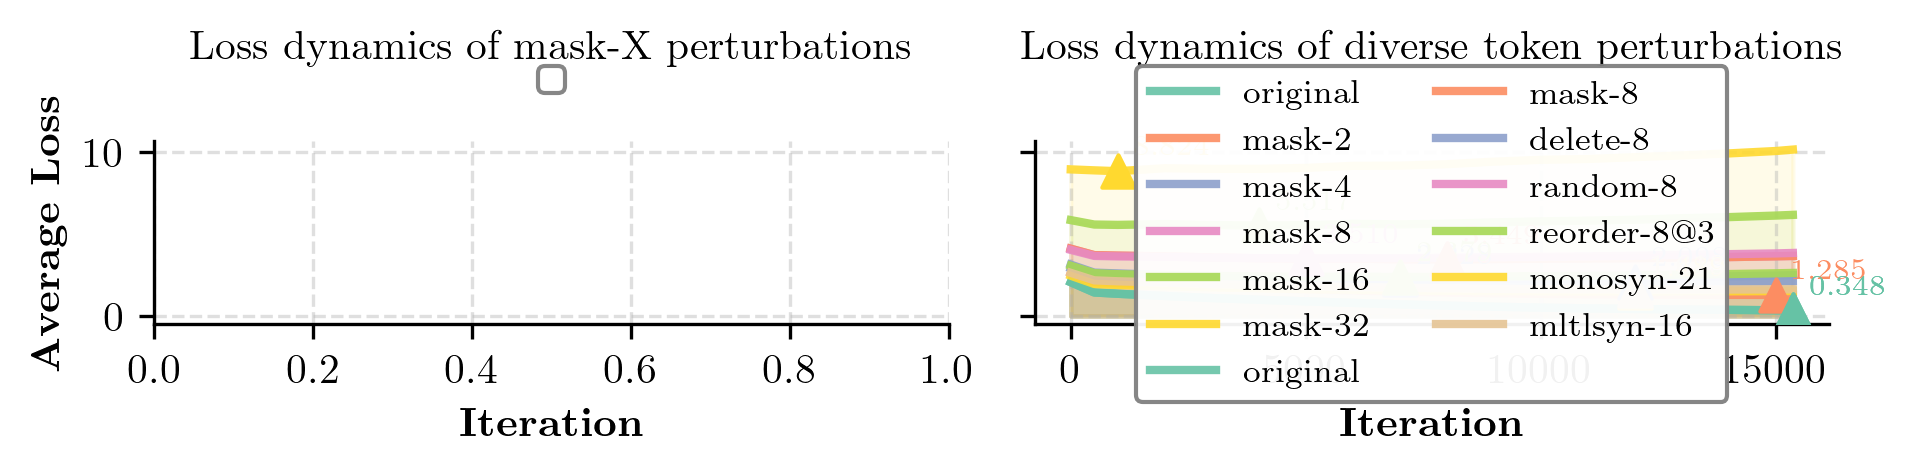

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib import rcParams

# Configure matplotlib for LaTeX-style rendering
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Times New Roman']
rcParams['text.usetex'] = True

# Define a fixed color palette
COLOR_PALETTE = sns.color_palette("Set2", 10)


# def collect_loss_data(name, variant):
#     """Mock placeholder function; replace with your actual data collection."""
#     iterations = np.arange(0, 10000, 500)
#     avg_losses = np.exp(-iterations / 4000) + np.random.rand(len(iterations)) * 0.05
#     noisy_rate = np.random.rand()
#     return iterations, avg_losses, noisy_rate


def plot_loss_curves(ax, items, mode="sequence", noisy_rate=None, show_noise_rate=False):
    """
    Plot loss curves on a given axis (sequence or distortion).
    """
    for i, item in enumerate(items):
        try:
            if mode == "sequence":
                iterations, avg_losses, _noisy_rate = collect_loss_data(item, "original")
            else:
                iterations, avg_losses, _noisy_rate = collect_loss_data("full", item)

            _noisy_rate = noisy_rate if noisy_rate is not None else _noisy_rate
            label = f'{item} ({_noisy_rate:.0%})' if show_noise_rate else f'{item}'

            # Rename certain labels
            if mode == "distortion":
                if label.startswith("retoken-"):
                    label = label.replace("retoken-", "reorder-")
                elif label.startswith("replace-"):
                    label = label.replace("replace-", "random-")
                elif label.startswith("rewrite@"):
                    label = label.replace("rewrite@", "")

            color = COLOR_PALETTE[i % len(COLOR_PALETTE)]
            ax.plot(iterations, avg_losses, label=label, color=color, linewidth=2, alpha=0.9)
            ax.fill_between(iterations, avg_losses, alpha=0.1, color=color)

            # Mark minimum
            min_idx = np.argmin(avg_losses)
            min_x, min_y = iterations[min_idx], avg_losses[min_idx]
            ax.scatter([min_x], [min_y], marker='^', s=60, color=color, zorder=5)
            ax.annotate(f'{min_y:.3f}', xy=(min_x, min_y), xytext=(4, 4),
                        textcoords='offset points', fontsize=7, color=color)
        except Exception as e:
            print(f"⚠️ Error plotting {item}: {str(e)}")
            continue


def plot_separate_legends(distortions1, distortions2, show_noise_rate=False):
    """Two subplots side-by-side sharing y-axis, each with its own legend above."""
    fig, axes = plt.subplots(1, 2, figsize=(6.5, 3.5), sharey=True)

    # Left subplot: sequence types
    # plot_loss_curves(axes[0], sequence_types, mode="sequence", show_noise_rate=show_noise_rate)
    plot_loss_curves(axes[1], distortions1, mode="distortion", show_noise_rate=show_noise_rate)
    axes[0].set_xlabel(r'\textbf{Iteration}', fontsize=10)
    axes[0].set_ylabel(r'\textbf{Average Loss}', fontsize=10)
    axes[0].grid(True, linestyle='--', alpha=0.4)
    axes[0].spines['top'].set_visible(False)
    axes[0].spines['right'].set_visible(False)
    axes[0].set_title(r'Loss dynamics of mask-X perturbations', fontsize=10, pad=20)

    # Legend above left subplot
    handles, labels = axes[0].get_legend_handles_labels()
    axes[0].legend(handles, labels,
                   loc='upper center',
                   bbox_to_anchor=(0.5, 1.3),
                   ncol=2,
                   fontsize=8,
                   frameon=True,
                   framealpha=0.95,
                   edgecolor='gray')

    # Right subplot: distortions
    plot_loss_curves(axes[1], distortions2, mode="distortion", show_noise_rate=show_noise_rate)
    axes[1].set_xlabel(r'\textbf{Iteration}', fontsize=10)
    axes[1].grid(True, linestyle='--', alpha=0.4)
    axes[1].spines['top'].set_visible(False)
    axes[1].spines['right'].set_visible(False)
    axes[1].set_title(r'Loss dynamics of diverse token perturbations', fontsize=10, pad=20)
    
    # Legend above right subplot
    handles, labels = axes[1].get_legend_handles_labels()
    axes[1].legend(handles, labels,
                   loc='upper center',
                   bbox_to_anchor=(0.5, 1.3),
                   ncol=2,
                   fontsize=8,
                   frameon=True,
                   framealpha=0.95,
                   edgecolor='gray')

    plt.tight_layout(rect=[0, 0, 1, 0.93])
    return fig


# ==== Example usage ====
# sequence_types = ["full", "partial-1", "partial-2", "partial-3", "partial-4"]
distortions1 = ["original", "mask-2", "mask-4", "mask-8", "mask-16", "mask-32"]
distortions2 = ["original", "mask-8", "delete-8", "replace-8", "retoken-8@3", "monosyn-21", "mltlsyn-16"]

fig = plot_separate_legends(distortions1, distortions2, show_noise_rate=False)
fig.savefig('./loss_figures/token-perturbations.pdf', format='pdf', bbox_inches='tight', dpi=300, transparent=True)
plt.show()

In [80]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib import rcParams

# Configure matplotlib for LaTeX-style rendering
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Times New Roman']
rcParams['text.usetex'] = True

# Define a fixed color palette
COLOR_PALETTE = sns.color_palette("Set2", 10)


def plot_loss_curves(ax, items, mode="sequence", noisy_rate=None, show_noise_rate=False):
    """Plot loss curves on a given axis (sequence or distortion)."""
    for i, item in enumerate(items):
        try:
            if mode == "sequence":
                iterations, avg_losses, _noisy_rate = collect_loss_data(item, "original")
            else:
                iterations, avg_losses, _noisy_rate = collect_loss_data("full", item)

            _noisy_rate = noisy_rate if noisy_rate is not None else _noisy_rate
            label = f'{item} ({_noisy_rate:.0%})' if show_noise_rate else f'{item}'

            # Normalize label names for readability
            if mode == "distortion":
                label = (
                    label.replace("retoken-", "reorder-")
                         .replace("replace-", "random-")
                         .replace("rewrite@", "")
                )

            color = COLOR_PALETTE[i % len(COLOR_PALETTE)]
            ax.plot(iterations, avg_losses, label=label, color=color, linewidth=2, alpha=0.9)
            ax.fill_between(iterations, avg_losses, alpha=0.1, color=color)

            # Mark minimum point
            min_idx = np.argmin(avg_losses)
            min_x, min_y = iterations[min_idx], avg_losses[min_idx]
            ax.scatter([min_x], [min_y], marker='^', s=60, color=color, zorder=5)
            ax.annotate(f'{min_y:.3f}', xy=(min_x, min_y), xytext=(4, 4),
                        textcoords='offset points', fontsize=7, color=color)
        except Exception as e:
            print(f"⚠️ Error plotting {item}: {str(e)}")
            continue


def plot_separate_legends(distortions1, distortions2, show_noise_rate=False, first_sequence=False):
    fig, axes = plt.subplots(1, 2, figsize=(6, 3.0), sharey=False)

    # === Left subplot ===
    if first_sequence:
        plot_loss_curves(axes[0], distortions1, mode="sequence", show_noise_rate=show_noise_rate)
    else:
        plot_loss_curves(axes[0], distortions1, mode="distortion", show_noise_rate=show_noise_rate)
    axes[0].set_xlabel(r'\textbf{Iteration}', fontsize=12)
    axes[0].set_ylabel(r'\textbf{Average Loss}', fontsize=12)
    if first_sequence:
        axes[0].set_title(r'\textbf{a) Partial Sentences}', fontsize=14, pad=10)
    else:
        axes[0].set_title(r'\textbf{a) Mask-X Perturbations}', fontsize=14, pad=10)
    axes[0].grid(True, linestyle='--', alpha=0.4)
    axes[0].spines['top'].set_visible(False)
    axes[0].spines['right'].set_visible(False)

    # === Right subplot ===
    plot_loss_curves(axes[1], distortions2, mode="distortion", show_noise_rate=show_noise_rate)
    axes[1].set_xlabel(r'\textbf{Iteration}', fontsize=12)
    if first_sequence:
        axes[1].set_title(r'\textbf{b) Diverse Sequential Perturbations}', fontsize=14, pad=10)
    else:
        axes[1].set_title(r'\textbf{b) Diverse Token Perturbations}', fontsize=14, pad=10)
    axes[1].grid(True, linestyle='--', alpha=0.4)
    axes[1].spines['top'].set_visible(False)
    axes[1].spines['right'].set_visible(False)

    # --- Create legends AFTER tight_layout (so layout ignores them)
    plt.tight_layout(rect=[0, 0, 1, 0.92])

    # Independent legends in figure coordinates
    legend_y_axis = 0.06
    handles_left, labels_left = axes[0].get_legend_handles_labels()
    legend_left = fig.legend(
        handles_left, labels_left, loc='upper left', bbox_to_anchor=(0.08, legend_y_axis),
        ncol=min(2, len(labels_left)), fontsize=11, frameon=True, framealpha=0.95, edgecolor='gray'
    )
    fig.add_artist(legend_left)

    handles_right, labels_right = axes[1].get_legend_handles_labels()
    legend_right = fig.legend(
        handles_right, labels_right, loc='upper right', bbox_to_anchor=(1, legend_y_axis),
        ncol=min(2, len(labels_right)), fontsize=11, frameon=True, framealpha=0.95, edgecolor='gray')
    fig.add_artist(legend_right)
    return fig

# def collect_loss_data(name, variant):
#     """Mock data for testing"""
#     iterations = np.arange(0, 10000, 500)
#     avg_losses = np.exp(-iterations / 4000) + np.random.rand(len(iterations)) * 0.05
#     noisy_rate = np.random.rand()
#     return iterations, avg_losses, noisy_rate


In [ ]:
distortions1 = ["original", "mask-2", "mask-4", "mask-8", "mask-16", "mask-32"]
distortions2 = ["original", "mask-8", "delete-8", "replace-8", "retoken-8@3", "monosyn-21", "mltlsyn-16"]

fig = plot_separate_legends(distortions1, distortions2, show_noise_rate=False)
fig.savefig('../figures/token-perturbations.pdf', format='pdf', bbox_inches='tight', dpi=300, transparent=True)


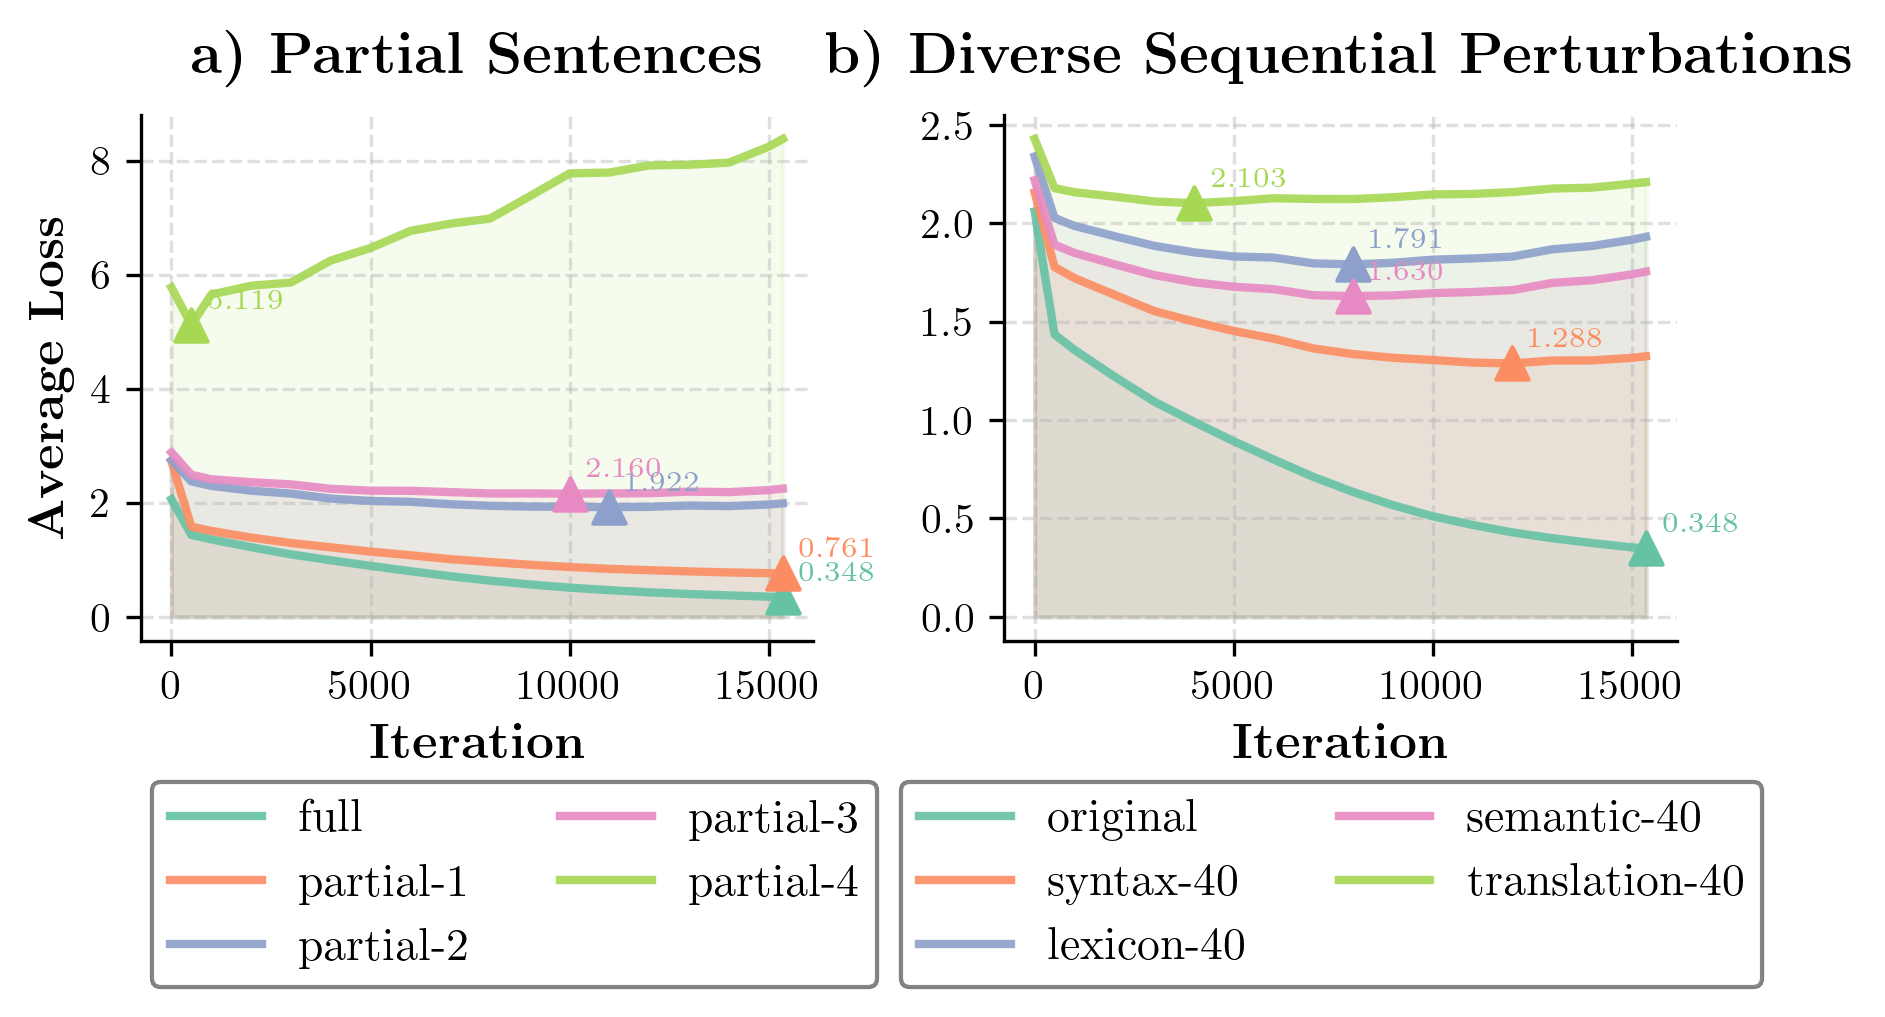

In [82]:
sequence_types = ["full", "partial-1", "partial-2", "partial-3", "partial-4"]
distortions2 = ["original", "rewrite@syntax-40", "rewrite@lexicon-40", "rewrite@semantic-40", "rewrite@translation-40"]

fig = plot_separate_legends(sequence_types, distortions2, show_noise_rate=False, first_sequence=True)
fig.savefig('../figures/perturbations-analysis-sequence.pdf', format='pdf', bbox_inches='tight', dpi=300, transparent=True)
# plt.show()


✓ Plotted full: 20 data points
✓ Plotted partial-1: 20 data points
✓ Plotted partial-2: 20 data points
✓ Plotted partial-3: 20 data points
✓ Plotted partial-4: 20 data points


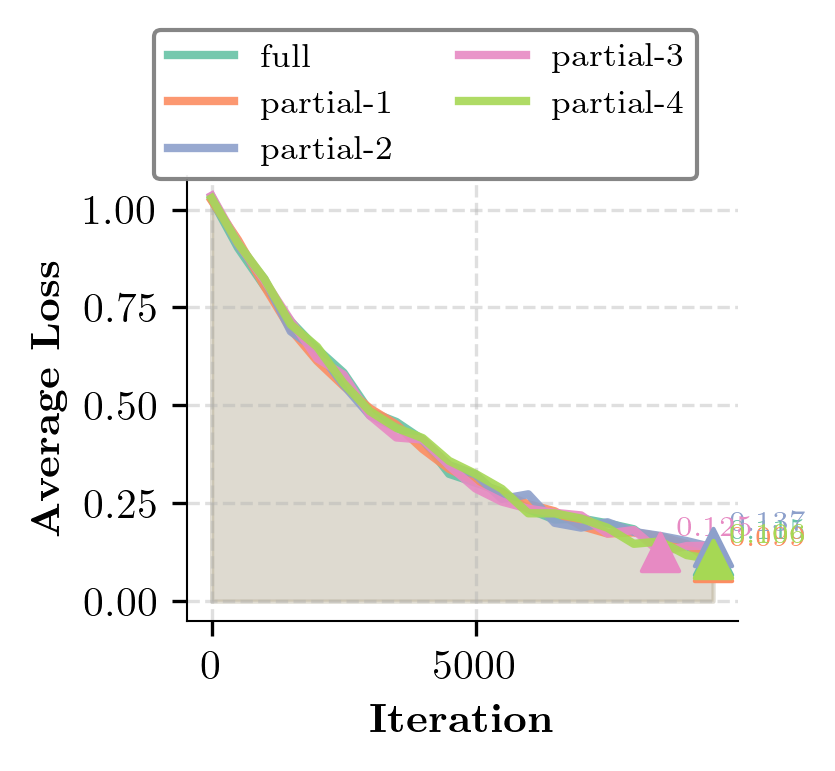

In [ ]:
sequence_types = ["full", "partial-1", "partial-2", "partial-3", "partial-4"]

fig = plot_multiple_loss_curves_by_sequence(sequence_types, show_noise_rate=False)
# fig.savefig('./loss_figures/en_jstage-partial-a.pdf', format='pdf', bbox_inches='tight', dpi=300, transparent=True)    

✓ Plotted original: 18 data points
✓ Plotted mask-2: 18 data points
✓ Plotted mask-4: 18 data points
✓ Plotted mask-8: 18 data points
✓ Plotted mask-16: 18 data points
✓ Plotted mask-32: 18 data points


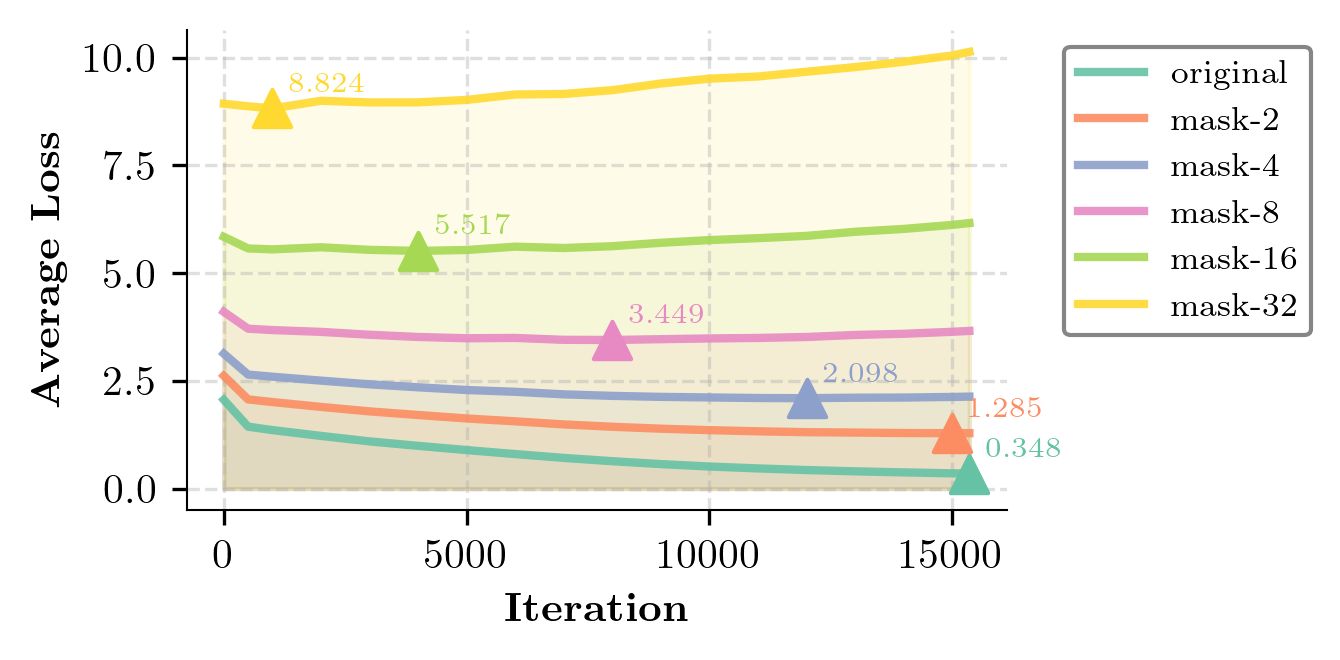

In [29]:
distortions = ["original", "mask-2", "mask-4", "mask-8", "mask-16", "mask-32"]
fig = plot_multiple_loss_curves_by_distortion(distortions, show_noise_rate=False)
fig.savefig('./loss_figures/en_jstage-mask.pdf', format='pdf', bbox_inches='tight', dpi=300, transparent=True)

✓ Plotted original: 18 data points
✓ Plotted mask-8: 18 data points
✓ Plotted delete-8: 18 data points
✓ Plotted replace-8: 18 data points
✓ Plotted retoken-8@3: 18 data points
✓ Plotted monosyn-21: 18 data points
✓ Plotted mltlsyn-16: 18 data points


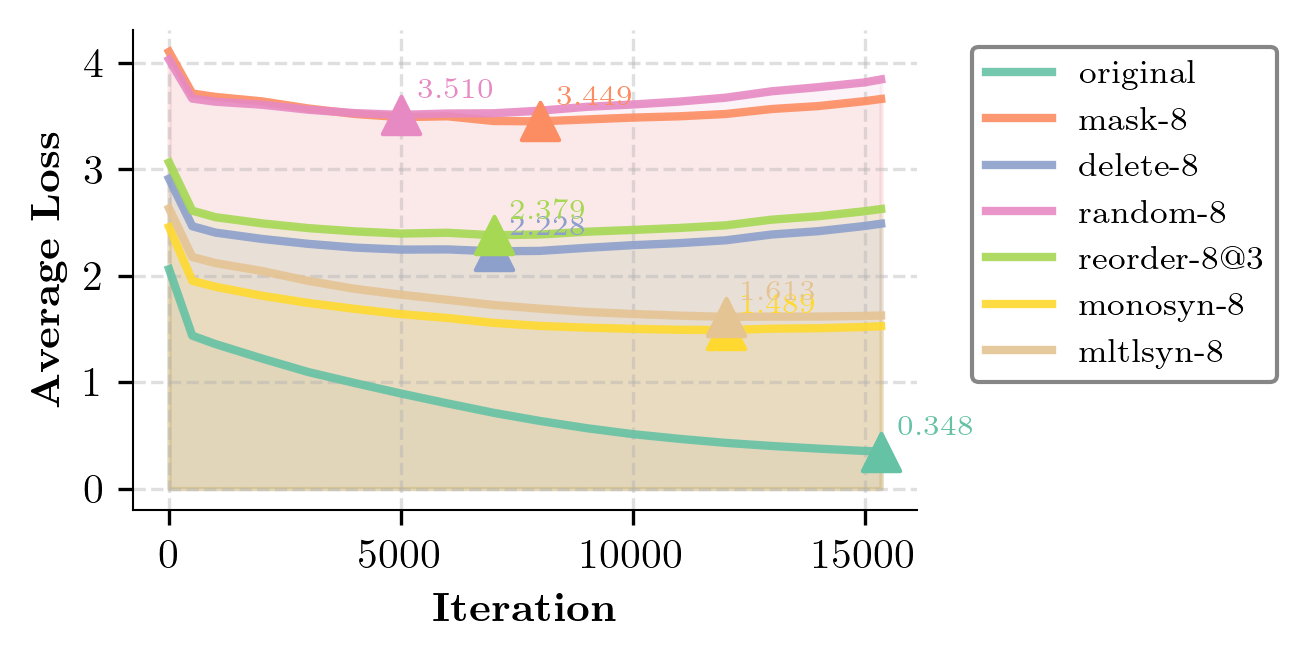

In [37]:
distortions = ["original", "mask-8", "delete-8", "replace-8", "retoken-8@3", "monosyn-21", "mltlsyn-16"]
fig = plot_multiple_loss_curves_by_distortion(distortions, title="Edit distance: 8%", noisy_rate=0.08, show_noise_rate=True)
fig.savefig('./loss_figures/en_jstage-8-edit-distance.pdf', format='pdf', bbox_inches='tight', dpi=300, transparent=True)

✓ Plotted original: 18 data points
✓ Plotted rewrite@syntax-40: 18 data points
✓ Plotted rewrite@lexicon-40: 18 data points
✓ Plotted rewrite@semantic-40: 18 data points
✓ Plotted rewrite@translation-40: 18 data points


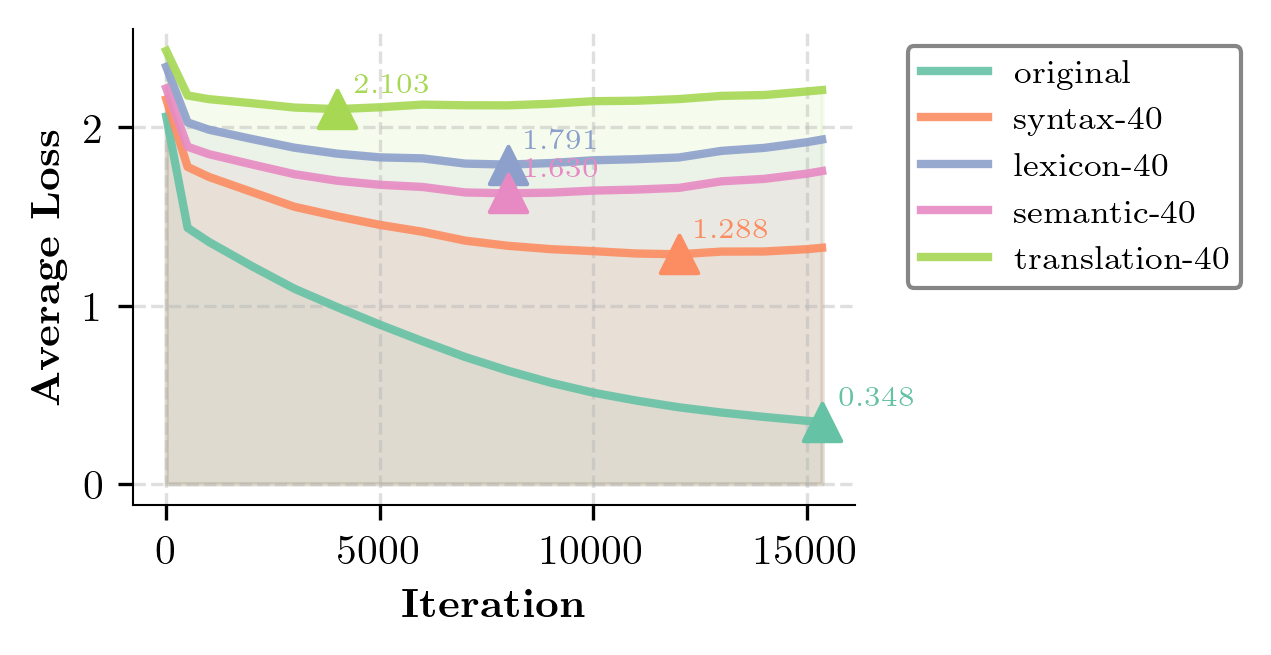

In [46]:
sequence_types = ["original", "rewrite@syntax-40", "rewrite@lexicon-40", "rewrite@semantic-40", "rewrite@translation-40"]
fig = plot_multiple_loss_curves_by_distortion(sequence_types, show_noise_rate=False)
fig.savefig('./loss_figures/en_jstage-setence-perturb-40.pdf', format='pdf', bbox_inches='tight', dpi=300, transparent=True)